# Phosphorus

Use conda environment python3

## Load libraries

In [1]:
import netcdf_tools
import numpy as np

## Select year

In [2]:
nbyr=10
years=range(1,nbyr+1)
array1d_iT_iTforplot=np.arange(1,365*nbyr+1)
array1d_iT_iTforpcolormesh=np.arange(1,365*nbyr+2)
locs=list()
xticklabels=range(5,nbyr+1,5)
for year in xticklabels:
    loc=1+365*(year-1)
    locs.append(loc)

## Read outputs

RF is the r coordinate of cell intrface (in m)

In [3]:
gridfile='grid.t001.nc';
RF=netcdf_tools.read_netcdf(gridfile,'RF')

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

it corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [4]:
drF=netcdf_tools.read_netcdf(gridfile,'drF')

In [5]:
gudfile='car.0000000000.t001.nc';

array2d_idepth_iT_PO4=netcdf_tools.read_netcdf(gudfile, 'TRAC05').squeeze().transpose() # PO4; mmol P m^-3
array2d_idepth_iT_DOP=netcdf_tools.read_netcdf(gudfile, 'TRAC10').squeeze().transpose() # DOP; mmol P m^-3
array2d_idepth_iT_POP=netcdf_tools.read_netcdf(gudfile, 'TRAC14').squeeze().transpose() # POP; mmol P m^-3

array2d_idepth_iT_biomass=netcdf_tools.read_netcdf(gudfile, 'TRAC21').squeeze().transpose() # phyto + zoo biomass; mmol C m^-3
array2d_idepth_iT_biomass[:,:]=0
for itracer in range(21,70):
    name=f'TRAC{itracer:02}'
#     print(name)
    array2d_idepth_iT_onelivingtracer=netcdf_tools.read_netcdf(gudfile, name).squeeze().transpose() # biomass; mmol C m^-3
    array2d_idepth_iT_biomass=array2d_idepth_iT_biomass+array2d_idepth_iT_onelivingtracer

R_PC=1/120 # See data.gud
array2d_idepth_iT_biomass=array2d_idepth_iT_biomass*R_PC # biomass; mmol P m^-3

array2d_idepth_iT_P=array2d_idepth_iT_PO4+array2d_idepth_iT_DOP+array2d_idepth_iT_POP+array2d_idepth_iT_biomass

# Prepare plots of $PO_4$, and $PO_4$+$DOP$+$POP$+P in phyto+P in zoo

In [6]:
import matplotlib
import matplotlib.pyplot as plt

In [7]:
# adapted from
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
# answer of Pedro M Duarte
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 28

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the x tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the y tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Vertical integration of phosphorus

In [8]:
import vstats

In [9]:
array1d_iT_P0to354  =vstats.vintegrate(array2d_idepth_iT_P, drF,  0, 73)
array1d_iT_P354to360=vstats.vintegrate(array2d_idepth_iT_P, drF, 73, 74)
array1d_iT_P0to360  =vstats.vintegrate(array2d_idepth_iT_P, drF,  0, 74)

# Annual drift of phosphorus

In [10]:
nbdepth=RF.size-1
array2d_idepth_iyr2tolast_deltaPO4=np.zeros((nbdepth,nbyr-1))
for iyr in range(2,nbyr+1):
    iTcurrent=365*(iyr-1)+364
    array1d_idepth_PO4current=array2d_idepth_iT_PO4[:,iTcurrent]
    iTprevious=365*(iyr-2)+364
    array1d_idepth_PO4previous=array2d_idepth_iT_PO4[:,iTprevious]
    array1d_idepth_deltaPO4=array1d_idepth_PO4current-array1d_idepth_PO4previous
    array2d_idepth_iyr2tolast_deltaPO4[:,iyr-2]=array1d_idepth_deltaPO4
array1d_iyr_yr=np.arange(1,nbyr+1)

# All plots on the same figure

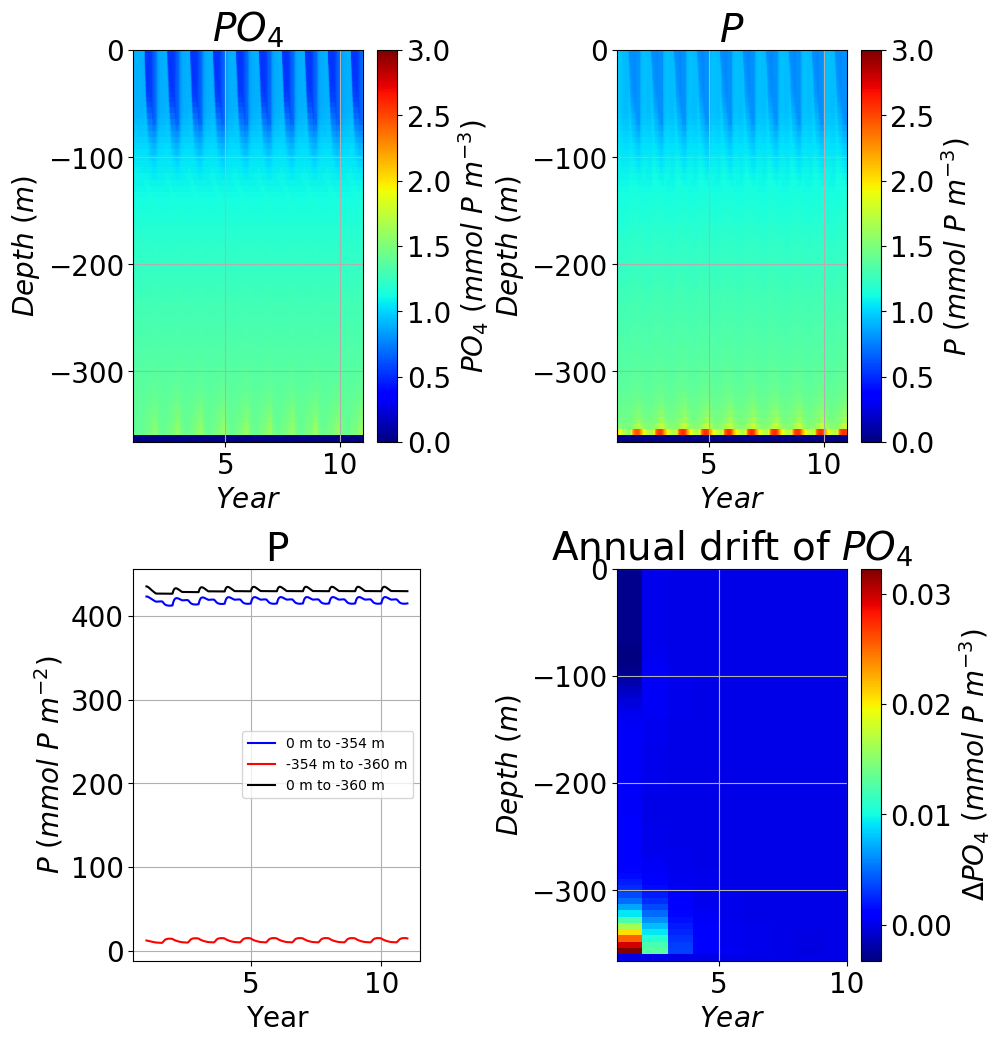

In [11]:
plt.figure(figsize=(10,15))

plt.subplot2grid(shape=(3,2), loc=(0,0))
plt.pcolormesh(array1d_iT_iTforpcolormesh,RF,
               array2d_idepth_iT_PO4,
               cmap='jet',
               vmin=0,
               vmax=3)
plt.title('$PO_4$')
plt.xlabel('$Year$')
plt.xticks(locs,xticklabels)
plt.ylabel('$Depth\ (m)$')
plt.grid(True)
cbar=plt.colorbar()
cbar.set_label('$PO_4\ (mmol\ P\ m^{-3})$')

plt.subplot2grid(shape=(3,2), loc=(0,1))
plt.pcolormesh(array1d_iT_iTforpcolormesh,RF,
               array2d_idepth_iT_P,
               cmap='jet',
               vmin=0,
               vmax=3)
plt.title('$P$')
plt.xlabel('$Year$')
plt.xticks(locs,xticklabels)
plt.ylabel('$Depth\ (m)$')
plt.grid(True)
cbar=plt.colorbar()
cbar.set_label('$P\ (mmol\ P\ m^{-3})$')

plt.subplot2grid(shape=(3,2), loc=(1,0))
plt.plot(array1d_iT_iTforplot,array1d_iT_P0to354,  color='blue', linestyle='-',
         label='0 m to -354 m')
plt.plot(array1d_iT_iTforplot,array1d_iT_P354to360,color='red',  linestyle='-',
         label='-354 m to -360 m')
plt.plot(array1d_iT_iTforplot,array1d_iT_P0to360,  color='black',linestyle='-',
         label='0 m to -360 m')
plt.legend(loc='lower right')
plt.title('P')
plt.xlabel('Year')
plt.ylabel('$P\ (mmol\ P\ m^{-2})$')
plt.grid(True)
plt.xticks(locs,xticklabels)
plt.legend()

plt.subplot2grid(shape=(3,2), loc=(1,1))
plt.pcolormesh(array1d_iyr_yr, RF,
               array2d_idepth_iyr2tolast_deltaPO4,
               cmap='jet')
plt.title('Annual drift of $PO_4$')
plt.xlabel('$Year$')
plt.ylabel('$Depth\ (m)$')
plt.grid(True)
cbar=plt.colorbar()
cbar.set_label('$\Delta PO_4\ (mmol\ P\ m^{-3})$')

plt.tight_layout()

plt.savefig('car.0000000000.t001.allyears.p.largecbar.png')

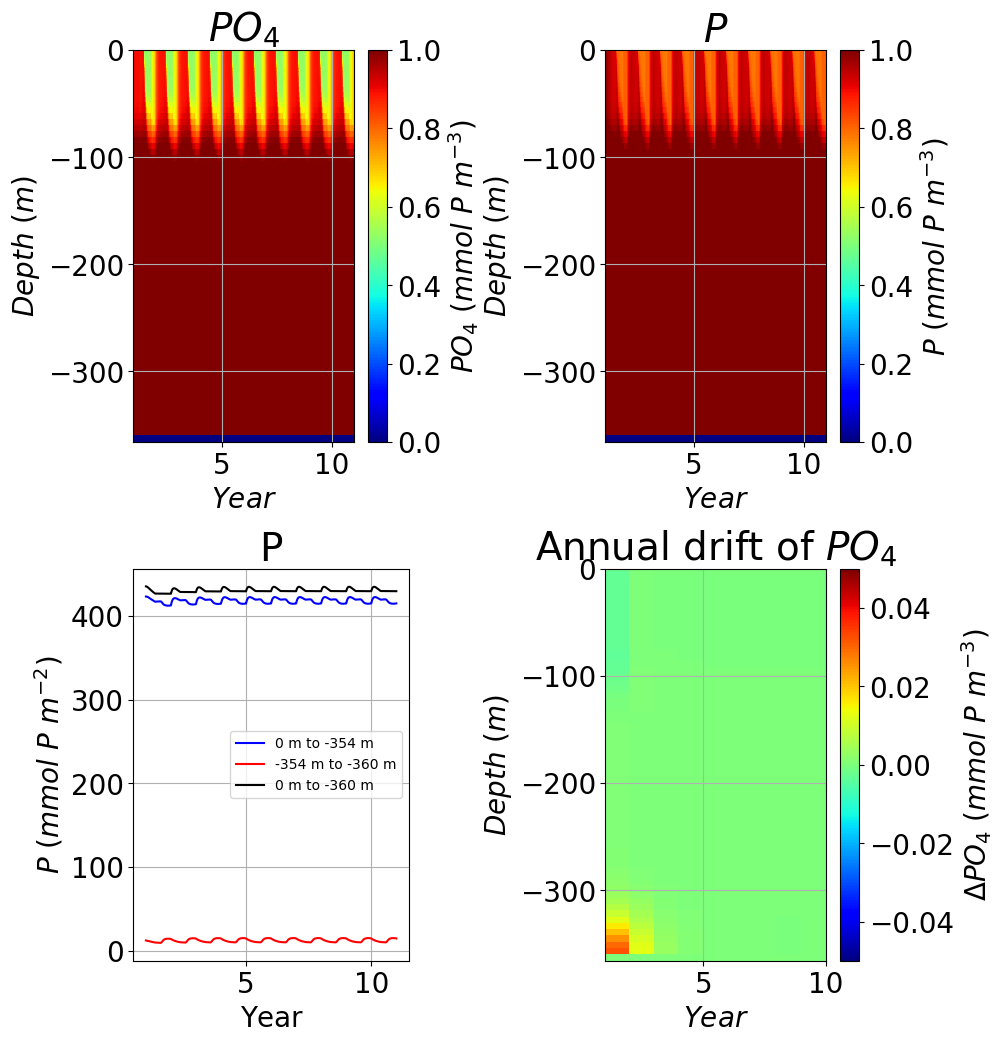

In [12]:
plt.figure(figsize=(10,15))

plt.subplot2grid(shape=(3,2), loc=(0,0))
plt.pcolormesh(array1d_iT_iTforpcolormesh,RF,
               array2d_idepth_iT_PO4,
               cmap='jet',
               vmin=0,
               vmax=1)
plt.title('$PO_4$')
plt.xlabel('$Year$')
plt.xticks(locs,xticklabels)
plt.ylabel('$Depth\ (m)$')
plt.grid(True)
cbar=plt.colorbar()
cbar.set_label('$PO_4\ (mmol\ P\ m^{-3})$')

plt.subplot2grid(shape=(3,2), loc=(0,1))
plt.pcolormesh(array1d_iT_iTforpcolormesh,RF,
               array2d_idepth_iT_P,
               cmap='jet',
               vmin=0,
               vmax=1)
plt.title('$P$')
plt.xlabel('$Year$')
plt.xticks(locs,xticklabels)
plt.ylabel('$Depth\ (m)$')
plt.grid(True)
cbar=plt.colorbar()
cbar.set_label('$P\ (mmol\ P\ m^{-3})$')

plt.subplot2grid(shape=(3,2), loc=(1,0))
plt.plot(array1d_iT_iTforplot,array1d_iT_P0to354,  color='blue', linestyle='-',
         label='0 m to -354 m')
plt.plot(array1d_iT_iTforplot,array1d_iT_P354to360,color='red',  linestyle='-',
         label='-354 m to -360 m')
plt.plot(array1d_iT_iTforplot,array1d_iT_P0to360,  color='black',linestyle='-',
         label='0 m to -360 m')
plt.legend(loc='lower right')
plt.title('P')
plt.xlabel('Year')
plt.ylabel('$P\ (mmol\ P\ m^{-2})$')
plt.grid(True)
plt.xticks(locs,xticklabels)
plt.legend()

plt.subplot2grid(shape=(3,2), loc=(1,1))
plt.pcolormesh(array1d_iyr_yr, RF,
               array2d_idepth_iyr2tolast_deltaPO4,
               cmap='jet',
               vmin=-0.05,
               vmax=0.05)
plt.title('Annual drift of $PO_4$')
plt.xlabel('$Year$')
plt.ylabel('$Depth\ (m)$')
plt.grid(True)
cbar=plt.colorbar()
cbar.set_label('$\Delta PO_4\ (mmol\ P\ m^{-3})$')

plt.tight_layout()

plt.savefig('car.0000000000.t001.allyears.p.smallcbar.png')

# Conclusion

**Is phosphorus at equilibrium?**

Yes.

**Is there a drift of phosphorus?**

$PO_4$ is in steady-state by year 8.

# Generation of individual plots

## Drift of $PO_4$

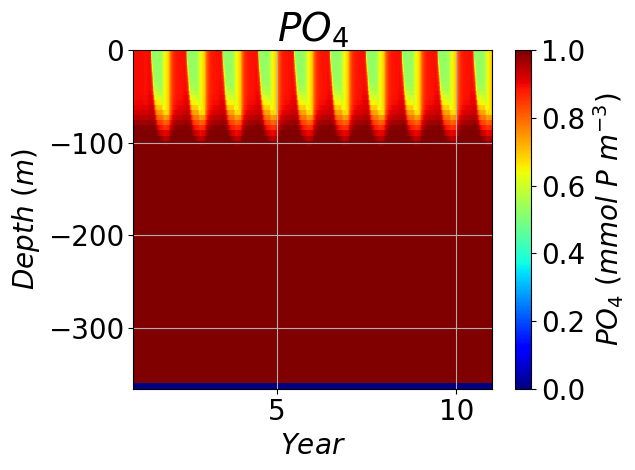

In [13]:
plt.figure(figsize=(6.4,4.8))
plt.pcolormesh(array1d_iT_iTforpcolormesh,RF,
               array2d_idepth_iT_PO4,
               cmap='jet',
               vmin=0,
               vmax=1)
plt.title('$PO_4$')
plt.xlabel('$Year$')
plt.xticks(locs,xticklabels)
plt.ylabel('$Depth\ (m)$')
plt.grid(True)
cbar=plt.colorbar()
cbar.set_label('$PO_4\ (mmol\ P\ m^{-3})$')
plt.tight_layout()
plt.savefig('car.0000000000.t001.allyears.p.PO4.png')

## Equilibrium of phosphorus

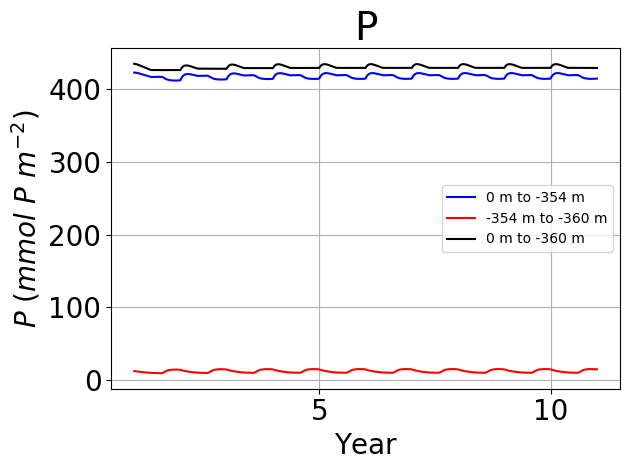

In [14]:
plt.figure(figsize=(6.4,4.8))
plt.plot(array1d_iT_iTforplot,array1d_iT_P0to354,  color='blue', linestyle='-',
         label='0 m to -354 m')
plt.plot(array1d_iT_iTforplot,array1d_iT_P354to360,color='red',  linestyle='-',
         label='-354 m to -360 m')
plt.plot(array1d_iT_iTforplot,array1d_iT_P0to360,  color='black',linestyle='-',
         label='0 m to -360 m')
plt.legend(loc='lower right')
plt.title('P')
plt.xlabel('Year')
plt.ylabel('$P\ (mmol\ P\ m^{-2})$')
plt.grid(True)
plt.xticks(locs,xticklabels)
plt.legend()
plt.tight_layout()
plt.savefig('car.0000000000.t001.allyears.p.vintP.png')

## Annual drift of $PO_4$

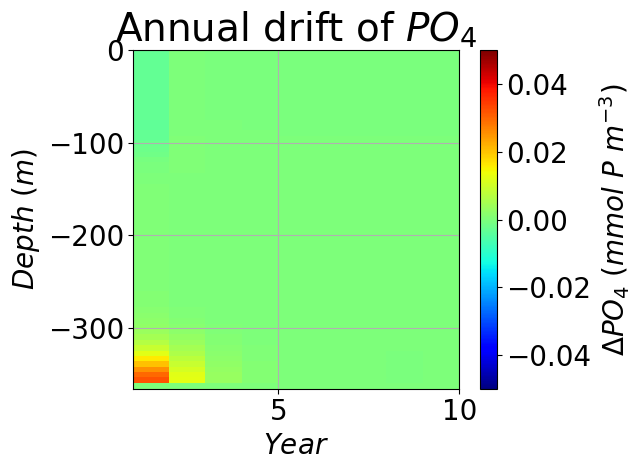

In [15]:
plt.figure(figsize=(6.4,4.8))
plt.pcolormesh(array1d_iyr_yr, RF,
               array2d_idepth_iyr2tolast_deltaPO4,
               cmap='jet',
               vmin=-0.05,
               vmax=0.05)
plt.title('Annual drift of $PO_4$')
plt.xlabel('$Year$')
plt.ylabel('$Depth\ (m)$')
plt.grid(True)
cbar=plt.colorbar()
cbar.set_label('$\Delta PO_4\ (mmol\ P\ m^{-3})$')
plt.tight_layout()
plt.savefig('car.0000000000.t001.allyears.p.deltaPO4.png')